<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/16_Transformer_emotion_recognizer_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.2 MB/s eta 0:00:00


In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, losses, optimizers

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

In [3]:
from datasets import load_dataset
emotions = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

VOCAB_SIZE

30522

In [15]:
MAX_LEN = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_mask = np.array(train_set['attention_mask'])
train_label = np.eye(6)[emotions['train']['label']]

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_mask = np.array(test_set['attention_mask'])
test_label = np.eye(6)[emotions['validation']['label']]

emotion_labels = emotions['train'].features['label'].names

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
transformer_model = models.load_model('/content/gdrive/My Drive/Transformer_emotion_reconginizer')
attention_scores_model = models.load_model('/content/gdrive/My Drive/Transformer_emotion_reconginizer_attention_scores')

In [18]:
input_text = [
    "I am so heartbroken that I don't know what to do.",
    "I am happy to be here with you.",
    "I'm caring about you as your mother.",
    "I'm irritated with your behavior.",
    "I'm afraid of what might happen to the people I love.",
    "I was shocked to see the broken window."]

tokenized_text = tokenizer(input_text, max_length=MAX_LEN,
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])
mask = np.array(tokenized_text['attention_mask'])

predictions = transformer_model.predict([input_ids, mask], verbose=0)

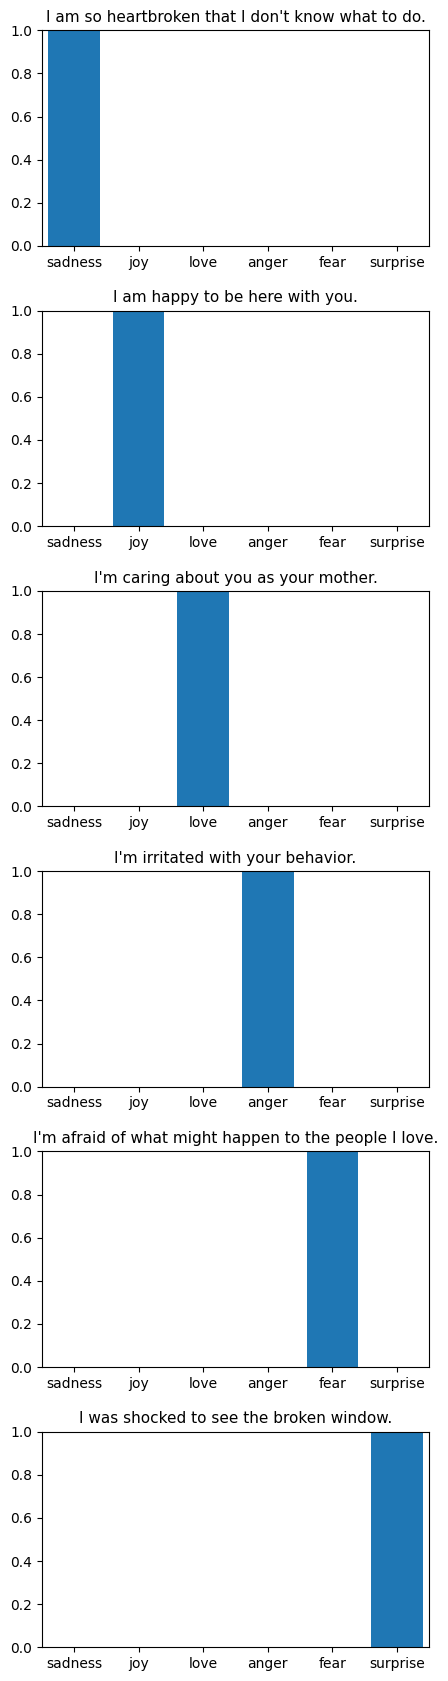

In [19]:
n = len(predictions)
fig = plt.figure(figsize=(5, 3.5 * n))
plt.subplots_adjust(hspace=0.3)

for c, pred in enumerate(predictions):
    subplot = fig.add_subplot(n, 1, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), pred, align='center')

In [28]:
pred, attention_scores1, attention_scores2 = attention_scores_model.predict([input_ids, mask], verbose=0)

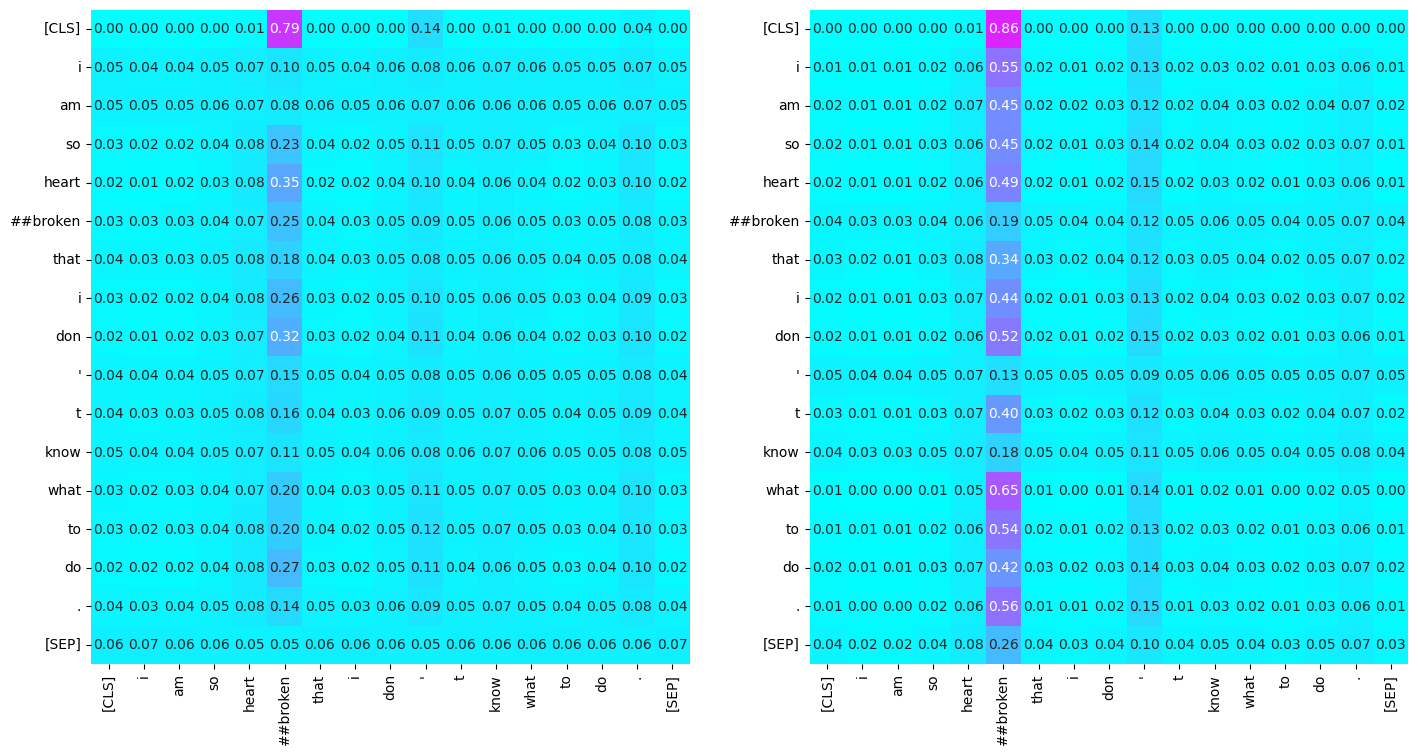

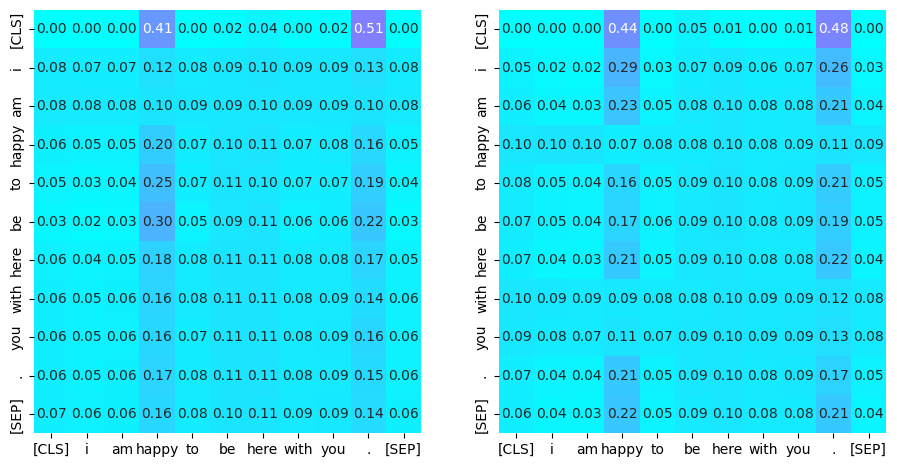

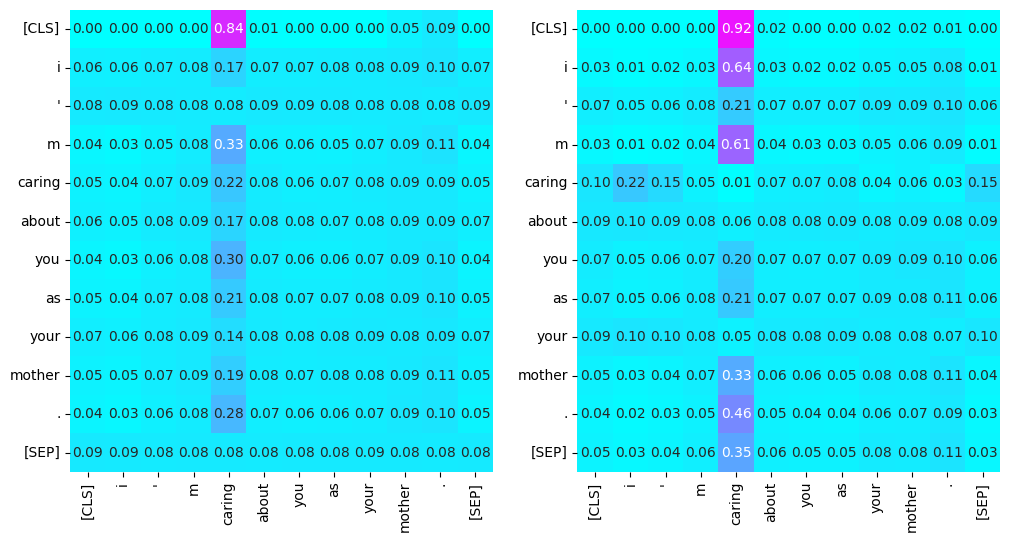

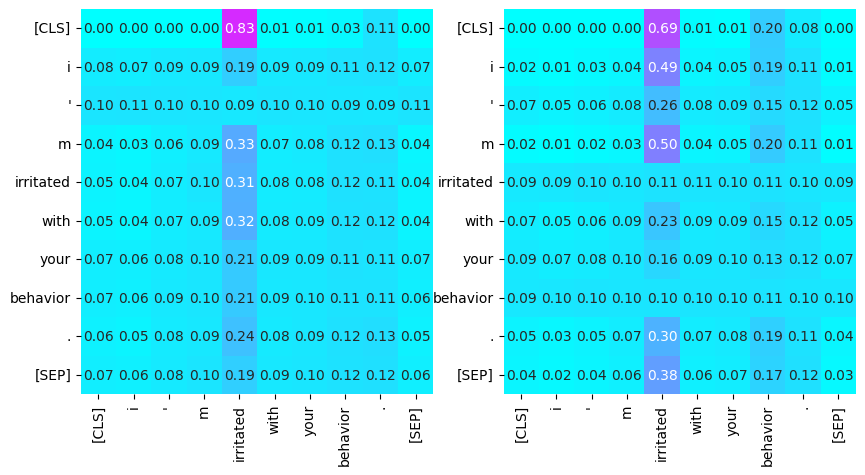

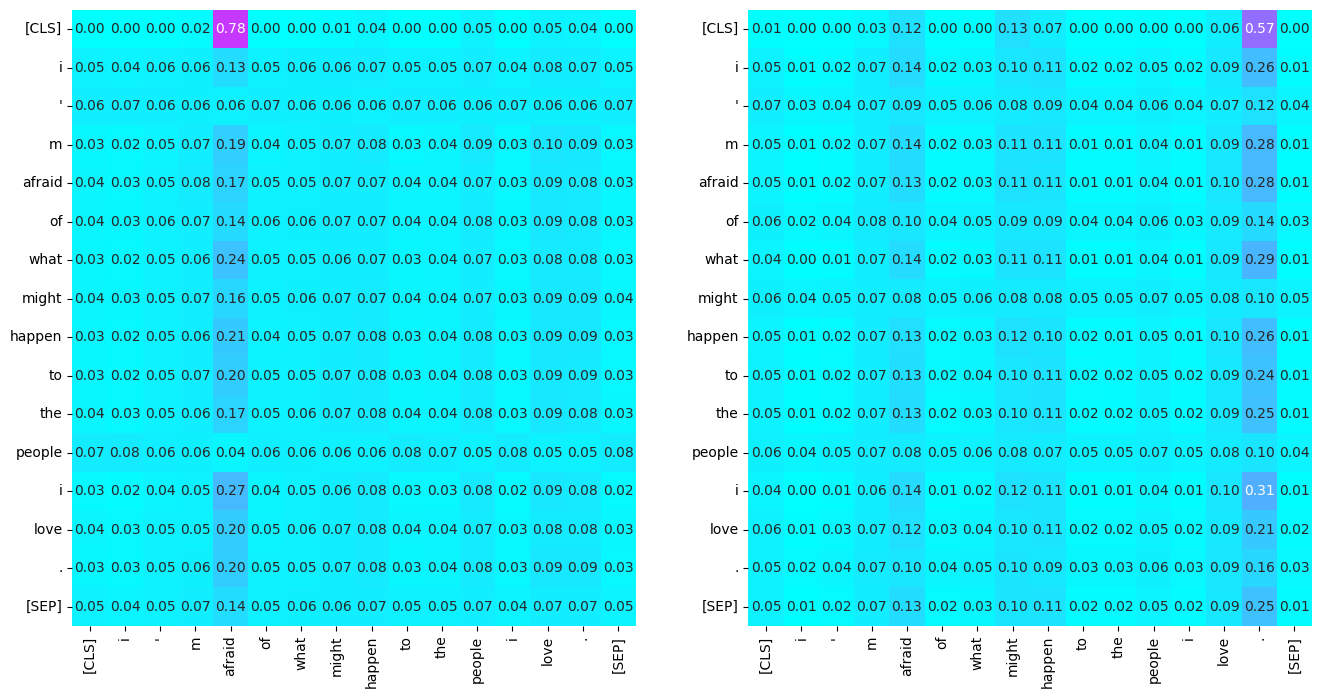

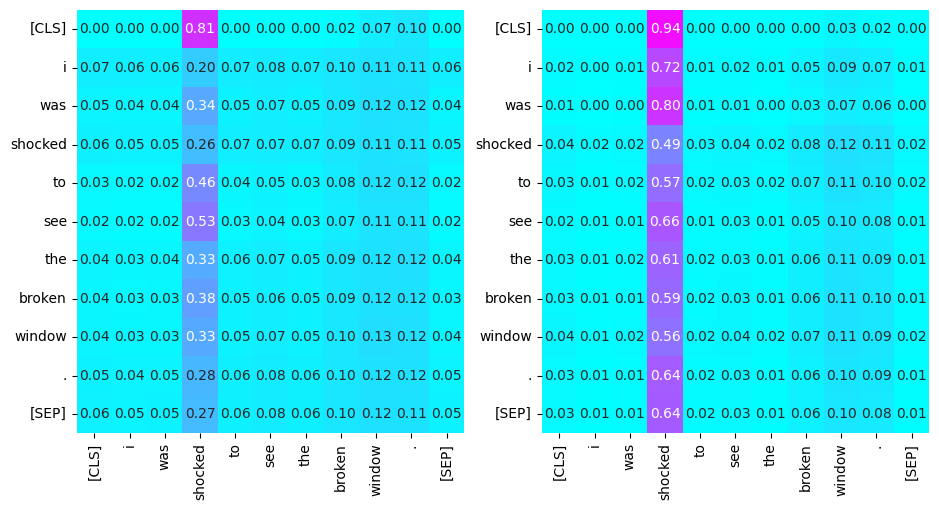

In [61]:
import seaborn as sns

for c, text in enumerate(input_text):
    labels = tokenizer.convert_ids_to_tokens(input_ids[c])
    text_len = sum(mask[c])
    fig = plt.figure(figsize=(text_len, text_len/2))
    subplot = fig.add_subplot(1, 2, 1)
    _ = sns.heatmap(np.mean(attention_scores1[c, :, :text_len, :text_len], axis=0),
                    ax = subplot,
                    xticklabels=labels[:text_len], yticklabels=labels[:text_len],
                    cmap='cool', vmin=0, vmax=1, cbar=False,
                    annot=True, fmt='1.2f')
    subplot = fig.add_subplot(1, 2, 2)
    _ = sns.heatmap(np.mean(attention_scores2[c, :, :text_len, :text_len], axis=0),
                    ax = subplot,
                    xticklabels=labels[:text_len], yticklabels=labels[:text_len],
                    cmap='cool', vmin=0, vmax=1, cbar=False,
                    annot=True, fmt='1.2f')
